In [105]:
import torch
import torchvision.transforms as transforms
import os
import torch.nn.functional as F
# 학습 중 진행상황 print(진행률 막대)
import tqdm
import random
import cv2
from ipywidgets import interact
# 파일 및 디렉토리 작업
import shutil
import numpy as np
from PIL import Image
import re
# 다차원 이미지 처리
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
# 파일경로 다루기
from pathlib import Path
from torch import nn
# 텐서를 감싸기
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split

# 0. 0_환경세팅

In [106]:
# from google.colab import drive
# drive.mount('/content/drive')

# # zip압축해제
# !unzip '/content/drive/MyDrive/03.Breast Cancer Segmentation/02. Unet_Dataset.zip' -d '/content/02. Unet_Dataset/'

# 1. 1_ 데이터셋 생성

In [107]:
# 데이터셋 클래스 정의
class BreastDatasets(Dataset):
    def __init__(self, img_dir, mask_dir, img_transform, mask_transform):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.img_files = []
        self.mask_files = []
        self.seed = np.random.randint(2024)

        for x in ['benign','malignant','normal']:
            file_img_dir = os.path.join(self.img_dir,x)
            file_mask_dir = os.path.join(self.mask_dir,x)
            for img_name in os.listdir(file_img_dir):
                if img_name.split('.')[-1] in ('png', 'jpg'):
                    self.img_files.append(os.path.join(file_img_dir, img_name))
                    self.mask_files.append(os.path.join(file_mask_dir, img_name))

    def __len__(self):
        return len(self.img_files)



    def __getitem__(self, i):
        img = Image.open(self.img_files[i]).convert('RGB')
        if self.img_transform is not None:
            # random.seed(self.seed)
            img = self.img_transform(img)

        mask = Image.open(self.mask_files[i]).convert('RGB')
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)
            mask = np.array(mask)
            mask = self.rgb_to_class(mask)
            mask = torch.from_numpy(mask).long()
            # mask = mask.transpose((1, 2, 0))
            # mask = torch.from_numpy(mask).long()
            #alt1
            # mask = torch.from_numpy(mask).permute(2, 0, 1)  # 채널 축 순서 변경
            # mask = mask.float()


        return img, mask

    def rgb_to_class(self, mask):
        class_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int64)
        class_mask[np.all(mask == [0, 0, 255], axis=-1)] = 1 # 파랑 : benigng
        class_mask[np.all(mask == [255, 0, 0], axis=-1)] = 2 # 빨강 : malignant
        class_mask[(class_mask != 1) & (class_mask != 2)] = 0  # 그 외의 색
        return class_mask

# 1-1_test

In [108]:
# 모델 저장 폴더
model_dir = '/content/model_weights2'
os.makedirs(model_dir, exist_ok=True)

# 데이터 저장 폴더
data_dir = '/content/02. Unet_Dataset'
DIR_IMG = os.path.join(data_dir, 'image')
DIR_MASK = os.path.join(data_dir, 'mask')

# transforms
channel_mean = [0.485, 0.456, 0.406]
channel_stds = [0.229, 0.224, 0.225]
train_tfms = transforms.Compose([transforms.ToTensor(), transforms.Resize(256),
                                 transforms.Normalize(channel_mean, channel_stds)])
val_tfms = transforms.Compose([transforms.ToTensor(), transforms.Resize(256),
                                 transforms.Normalize(channel_mean, channel_stds)])
mask_tfms = transforms.Compose([transforms.ToTensor(), transforms.Resize(256)])

img_files = []
mask_files = []

for x in ['benign','malignant','normal']:
    file_img_dir = os.path.join(DIR_IMG,x)
    file_mask_dir = os.path.join(DIR_MASK,x)
    for img_name in os.listdir(file_img_dir):
        if img_name.split('.')[-1] in ('png', 'jpg'):
            img_files.append(os.path.join(file_img_dir, img_name))
            mask_files.append(os.path.join(file_mask_dir, img_name))

In [109]:
def rgb_to_class(mask):
    class_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int64)
    class_mask[np.all(mask == [0, 0, 0], axis=-1)] = 0 #검정 : noraml
    class_mask[np.all(mask == [0, 0, 255], axis=-1)] = 1 # 파랑 : benigng
    class_mask[np.all(mask == [255, 0, 0], axis=-1)] = 2 # 빨강 : malignant
    return class_mask

In [110]:
mask = Image.open(mask_files[0]).convert('RGB')
# mask = mask.transpose((1, 2, 0))
# mask = torch.from_numpy(mask).permute(2, 0, 1)  # 채널 축 순서 변경

# mask = torch.from_numpy(mask).long()
mask = np.array(mask)
mask = rgb_to_class(mask)
# mask = mask_tfms(mask)

# mask = rgb_to_class(mask)
# mask = torch.from_numpy(mask).long()



# class_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int64)
# class_mask[np.all(mask == [0, 0, 0], axis=-1)] = 0 #검정 : noraml
# class_mask[np.all(mask == [0, 0, 255], axis=-1)] = 1 # 파랑 : benigng
# class_mask[np.all(mask == [255, 0, 0], axis=-1)] = 2 # 빨강 : malignant

# mask = torch.from_numpy(mask).long()
print(mask.shape, mask)
# plt.imshow(mask)
mask

set(mask.flatten().tolist())

(256, 256) [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


{0, 1}

# 2. 2_Unet 구현

In [111]:
# UNET 클래스로 구현
class UNet(nn.Module):
    # 클래스의 갯수 상속
    def __init__(self, num_classes):
        # nn.Module(부모) 클래스의 기능을 상속
        super(UNet, self).__init__()
        self.num_classes = num_classes
        # 3채널을 받아서 64로 반환(1번째 레이어)
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 64채널을 받아서 128채널로 반환(2번째 레이어)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 128채널을 받아서 256채널로 반환(3번째 레이어)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 64채널을 받아서 128채널로 반환(4번째 레이어)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 512채널을 받아서 1024채널로 반환(5번째 레이어)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        # 디코딩(확장)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        # 3
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        # 4
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        # 결과물
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1, stride=1)


    # n개의 채널을 받아서 n개의 채널로 내보내는 함수
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                             nn.ReLU(),
                             nn.BatchNorm2d(num_features=out_channels),
                             nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                             nn.ReLU(),
                             nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):
        # 컨볼루션 연산 -> 채널 상승
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256] : 배치 / 채널 / 이미지사이즈
        # 맥스풀링 -> 이미지 크기 감소
        contracting_12_out = self.contracting_12(contracting_11_out) #[-1, 64, 128, 128]
        # 2
        contracting_21_out = self.contracting_21(contracting_12_out) #[-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) #[-1, 128, 64, 64]
        # 3
        contracting_31_out = self.contracting_31(contracting_22_out) #[-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) #[-1, 256, 32, 32]
        # 4
        contracting_41_out = self.contracting_41(contracting_32_out) #[-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) #[-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]

    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1,512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024,32,32] -> [-1, 512,32,32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [112]:
# # UNET 클래스로 구현
# class UNet(nn.Module):
#     # 클래스의 갯수 상속
#     def __init__(self, num_classes):
#         # nn.Module(부모) 클래스의 기능을 상속
#         super(UNet, self).__init__()
#         self.num_classes = num_classes
#         # 3채널을 받아서 64로 반환(1번째 레이어)
#         self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
#         self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
#         # 64채널을 받아서 128채널로 반환(2번째 레이어)
#         self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
#         self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
#         # 128채널을 받아서 256채널로 반환(3번째 레이어)
#         self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
#         self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
#         # 64채널을 받아서 128채널로 반환(4번째 레이어)
#         self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
#         self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
#         # 512채널을 받아서 1024채널로 반환(5번째 레이어)
#         self.middle = self.conv_block(in_channels=512, out_channels=1024)
#         self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
#         self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
#         # 디코딩(확장)
#         self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
#         self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
#         # 3
#         self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
#         self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
#         # 4
#         self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
#         self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
#         # 결과물
#         self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=2)


#     # n개의 채널을 받아서 n개의 채널로 내보내는 함수
#     def conv_block(self, in_channels, out_channels):
#         block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
#                              nn.ReLU(),
#                              nn.BatchNorm2d(num_features=out_channels),
#                              nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
#                              nn.ReLU(),
#                              nn.BatchNorm2d(num_features=out_channels))
#         return block

#     def forward(self, X):
#         # 컨볼루션 연산 -> 채널 상승
#         contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256] : 배치 / 채널 / 이미지사이즈
#         # 맥스풀링 -> 이미지 크기 감소
#         contracting_12_out = self.contracting_12(contracting_11_out) #[-1, 64, 128, 128]
#         # 2
#         contracting_21_out = self.contracting_21(contracting_12_out) #[-1, 128, 128, 128]
#         contracting_22_out = self.contracting_22(contracting_21_out) #[-1, 128, 64, 64]
#         # 3
#         contracting_31_out = self.contracting_31(contracting_22_out) #[-1, 256, 64, 64]
#         contracting_32_out = self.contracting_32(contracting_31_out) #[-1, 256, 32, 32]
#         # 4
#         contracting_41_out = self.contracting_41(contracting_32_out) #[-1, 512, 32, 32]
#         contracting_42_out = self.contracting_42(contracting_41_out) #[-1, 512, 16, 16]
#         middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]

#     def forward(self, X):
#         contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
#         contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
#         contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
#         contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
#         contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
#         contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
#         contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
#         contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
#         middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
#         expansive_11_out = self.expansive_11(middle_out) # [-1,512, 32, 32]
#         expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024,32,32] -> [-1, 512,32,32]
#         expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
#         expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
#         expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
#         expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
#         expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
#         expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
#         output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
#         return output_out

# 3. 3_Dice Score와 IoU 메트릭 함수 정의하기

## 1. 코드설명
- dice_coeff
1.

In [113]:
def dice_coeff(input, target, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # 타겟 텐서가 3차원일 경우 4차원으로 확장
    if target.dim() == 3:
        target = target.unsqueeze(dim=1)

    # 입력과 타겟의 크기가 동일한지 확인
    assert input.size()[0] == target.size()[0] and input.size()[2:] == target.size()[2:], "Input and target must have compatible size."

    # 클래스 수 (C) 가져오기
    num_classes = input.size(1)

    # 타겟을 one-hot 인코딩으로 변환
    target_one_hot = torch.zeros_like(input).scatter_(1, target, 1)

    # Dice 계수 계산을 위한 합산 차원 정의
    sum_dim = (-1, -2, -3) if reduce_batch_first else (-1, -2)

    # 교집합 계산
    inter = 2 * (input * target_one_hot).sum(dim=sum_dim)

    # 집합 합 계산
    sets_sum = input.sum(dim=sum_dim) + target_one_hot.sum(dim=sum_dim)

    # 0으로 나누는 것을 방지
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    # Dice 계수 계산
    dice = (inter + epsilon) / (sets_sum + epsilon)

    # Dice 계수 반환
    return dice.mean()

def iou(y_pred, y_true, epsilon: float = 1e-6):
    """
    y_true: torch.Tensor, shape [B, 1, H, W] 또는 [B, H, W] (타겟 값)
    y_pred: torch.Tensor, shape [B, C, H, W] (예측 값)
    epsilon: float, 0으로 나누는 것을 방지하기 위한 작은 값
    """
    # y_true가 3차원일 경우 4차원으로 확장
    if y_true.dim() == 3:
        y_true = y_true.unsqueeze(dim=1)

    # 입력과 타겟의 배치 크기와 공간 차원이 동일한지 확인
    assert y_true.size(0) == y_pred.size(0) and y_true.size()[2:] == y_pred.size()[2:], "Input and target must have compatible sizes."

    # 클래스 수 (C) 가져오기
    num_classes = y_pred.size(1)

    # 타겟을 one-hot 인코딩으로 변환
    y_true_one_hot = torch.zeros_like(y_pred).scatter_(1, y_true, 1)

    # 교집합 계산
    intersection = (y_true_one_hot * y_pred).sum(dim=(2, 3))

    # 합집합 계산
    union = y_true_one_hot.sum(dim=(2, 3)) + y_pred.sum(dim=(2, 3)) - intersection

    # IOU 계산
    iou = (intersection + epsilon) / (union + epsilon)

    # 배치에 대해 평균 IOU 반환
    return iou.mean()

In [114]:
# # Dice coefficient: 두 개의 집합 간의 유사성을 측정하는 데 사용되는 통계적인 지표
# # 2×∣A∩B∣ / ∣A∣+∣B∣
# # 0에서 1까지의 값을 가지며, 1에 가까울수록 두 집합이 유사
# # 1e-6: 0.000001
# def dice_coeff(input, target, reduce_batch_first: bool = False, epsilon: float = 1e-6):
#     # assert 조건, "에러 메세지"
#     # assert input.size() == target.size()
#     # assert input.dim() == 3 or not reduce_batch_first
#     if target.dim() == 3:
#         target = target.unsqueeze(dim=1)
#     sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)
#     inter = 2*(input * target).sum(dim=sum_dim)
#     sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
#     # torch.where(): 조건에 따른 연산함수
#     sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

#     dice = (inter + epsilon) / (sets_sum + epsilon)
#     return dice.mean()


# # IoU(Intersection over Union): 객체 검출 및 객체 분할과 같은 컴퓨터 비전 작업에서 사용되는 평가 지표
# # 두 개의 영역 또는 객체가 주어졌을 때, IoU는 교집합을 합집합으로 나눈 것을 나타냄. 0에서 1사이의 값을 갖음
# def iou(y_true, y_pred, epsilon: float = 1e-6):
#     intersection = (y_true * y_pred).sum()
#     union = y_true.sum() + y_pred.sum() - intersection
#     return (intersection + epsilon) / (union + epsilon)

In [115]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def find_latest_model_path(dir):
    model_paths = []
    epochs = []
    for path in Path(dir).glob('*.pth'):
        if 'epoch' not in path.stem:
            continue
        model_paths.append(path)
        parts = path.stem.split('_')
        epoch = int(parts[-1])
        epochs.append(epoch)

    if len(epochs) > 0:
        epochs = np.array(epochs)
        max_idx = np.argmax(epochs)
        return model_paths[max_idx]
    else:
        return None

# param_groups: 옵티마이저 객체 속성. 요소는 딕셔너리이며 매개변수 그룹에 대한 정보를 저장
def adjust_learning_rate(optimizer, epoch, lr):
    lr = lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# 4. 4_train/valid 함수정의

In [116]:
def train(train_loader, model, criterion, optimizer, valid_loader, model_dir, n_epoch, batch_size, lr, device):
    latest_model_path = find_latest_model_path(model_dir)
    best_model_path = os.path.join(*[model_dir, 'model_best.pth'])

    # 모델 학습 파일 지정
    if latest_model_path is not None:
        state = torch.load(latest_model_path)
        epoch = state['epoch']
        model.load_state_dict(state['model'])
        assert Path(best_model_path).exists() == True, f'best model path {best_model_path} does not exist!'
        best_state = torch.load(latest_model_path)
        min_val_los = best_state['valid_loss']

        print(f'Restored model: {epoch}, Min validation loss: {min_val_los}')
        epoch += 1
        print(f'{epoch}')
    else:
        print('epoch: 0')
        epoch = 0
        min_val_los = 9999

    valid_losses = []
    # 학습 부분
    for epoch in range(epoch, n_epoch):
        adjust_learning_rate(optimizer, epoch, lr)
        tq = tqdm.tqdm(total=(len(train_loader) * batch_size), dynamic_ncols=True)
        tq.set_description(f'Epoch {epoch}')

        losses = AverageMeter()
        t_iou = 0
        t_dice = 0

        model.train()
        for i, (input, target) in enumerate(train_loader):
            # Variable: 텐서를 대체하기 위해 사용되던 클래스(과거 버전의 텐서)
            input_var = Variable(input).to(device)
            target_var = Variable(target).to(device)
            input_var = input.to(device)
            target_var = target.to(device)


            masks_pred = model(input_var)
            pred = torch.softmax(masks_pred, dim=1)
            # target_mask = target_var.squeeze(1)
            # 예측 활성화 함수
            pred_classes = torch.argmax(pred, dim=1)
            # target_classes = torch.argmax(target_mask, dim=1).unsqueeze(1)

            t_dice += dice_coeff(masks_pred, target_var)
            t_iou += iou(masks_pred, target_var)

            loss = criterion(masks_pred, target_var)
            losses.update(loss)
            tq.set_postfix(loss='{:.5f}'.format(losses.avg))
            tq.update(batch_size)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            last_input = input
            last_target = target
            last_pred = pred

        # last 이미지 확인(for문 종료 시)
        visualize_images(last_input, last_target, last_pred, 0.5)

        print(f'train miou : {t_iou/len(train_loader):.5f} train dice score : {t_dice/len(train_loader):.5f}')
        valid_metrics = valid(model, valid_loader, criterion)
        valid_loss = valid_metrics['valid_loss']
        valid_dice = valid_metrics['v_dice']
        valid_iou = valid_metrics['v_iou']
        valid_losses.append(valid_loss)
        print(f'valid_loss = {valid_loss:.5f}')
        print(f'valid miou : {valid_iou/len(valid_loader):.5f} valid dice score : {valid_dice/len(valid_loader):.5f}')
        tq.close()

        # dice / iou 지정
        t_dice = t_dice/len(train_loader)
        t_iou = t_iou/len(train_loader)
        valid_iou = valid_iou/len(valid_loader)
        valid_dice = valid_dice/len(valid_loader)

        epoch_model_path = os.path.join(*[model_dir, f'model_epoch_{epoch}.pth'])
        torch.save({
            'model': model.state_dict(),
            'epoch': epoch,
            'valid_loss': valid_loss,
            'valid_dice' : valid_dice,
            'valid_iou' : valid_iou,
            'train_loss': losses.avg,
            'train_dice' : t_dice,
            'train_iou' : t_iou
        }, epoch_model_path)

        if valid_loss < min_val_los:
            min_val_los = valid_loss

            torch.save({
                'model': model.state_dict(),
                'epoch': epoch,
                'valid_loss': valid_loss,
                'valid_dice' : valid_dice,
                'valid_iou' : valid_iou,
                'train_loss': losses.avg,
                'train_dice' : t_dice,
                'train_iou' : t_iou
            }, best_model_path)

# valid함수
def valid(model, val_loader, criterion):
    losses = AverageMeter()
    v_iou = 0
    v_dice = 0
    model.eval()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            input_var = Variable(input).to(device)
            target_var = Variable(target).to(device)
            output = model(input_var)
            loss = criterion(output, target_var)
            losses.update(loss.item(), input_var.size(0))
            pred = torch.softmax(output, dim=1)
            target_mask = target_var

            v_dice += dice_coeff(pred, target_mask)
            v_iou += iou(pred, target_mask)

    return {'valid_loss': losses.avg, 'v_dice': v_dice, 'v_iou': v_iou}

In [117]:
def class_to_rgb(class_mask):
    rgb_mask = np.zeros((class_mask.shape[0], class_mask.shape[1], 3), dtype=np.uint8)
    rgb_mask[class_mask == 1] = [0, 0, 255]  # 파랑 : benign
    rgb_mask[class_mask == 2] = [255, 0, 0]  # 빨강 : malignant
    return rgb_mask

def visualize_images(input_img, target_mask, pred_mask, alpha=0.4):
    # 배치 크기가 포함된 경우 첫 번째 이미지만 사용
    input_img = input_img[0].cpu().numpy().transpose(1, 2, 0)
    target_mask = target_mask[0].cpu().numpy()
    pred_mask = torch.argmax(pred_mask[0], dim=0).cpu().numpy()

    target_mask = class_to_rgb(target_mask)
    pred_mask = class_to_rgb(pred_mask)
    reverse_mask = 255 - pred_mask

    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(input_img)
    axs[0].imshow(target_mask, alpha=alpha)
    axs[0].set_title('Target Mask')
    axs[0].axis('off')

    axs[1].imshow(input_img)
    axs[1].imshow(pred_mask, alpha=alpha)
    axs[1].set_title('Predicted Mask')
    axs[1].axis('off')

    axs[2].imshow(input_img)
    axs[2].imshow(reverse_mask, alpha=alpha)
    axs[2].set_title('Predicted Mask2')
    axs[2].axis('off')

    plt.show()

# 5. 5_학습용 파라미터 정의

In [118]:
# 모델 저장 폴더
model_dir = '/content/drive/MyDrive/03.Breast Cancer Segmentation/model_weights/240604_train1'
os.makedirs(model_dir, exist_ok=True)

# 데이터 저장 폴더
data_dir = '/content/02. Unet_Dataset'
DIR_IMG = os.path.join(data_dir, 'image')
DIR_MASK = os.path.join(data_dir, 'mask')

# Device 할당
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.001
momentum = 0.9
weight_decay = 1e-4
batch_size = 4
num_workers = 8
n_epoch = 20

In [119]:
# device
# print(torch.cuda.get_device_name())

# 6. 6_학습 사전 TEST

In [120]:
# dataiter = iter(train_loader)
# image, target = next(dataiter)
# image, target = image.to(device), target.to(device)
# pred = model(image)

# print(image.shape, target.shape, pred.shape)
# test = target[0].cpu().numpy()
# plt.imshow(test, cmap='gray')

In [121]:
# test = target[0].cpu().numpy()
# new_target = class_to_rgb(test)
# plt.imshow(new_target, cmap='gray')

In [122]:
# def class_to_rgb(class_mask):
#     rgb_mask = np.zeros((class_mask.shape[0], class_mask.shape[1], 3), dtype=np.uint8)
#     rgb_mask[class_mask == 1] = [0, 0, 255]  # 파랑 : benign
#     rgb_mask[class_mask == 2] = [255, 0, 0]  # 빨강 : malignant
#     return rgb_mask

# def visualize_images2(input_img, target_mask, pred_mask, alpha=0.4):
#     # 배치 크기가 포함된 경우 첫 번째 이미지만 사용
#     input_img = input_img[0].cpu().numpy().transpose(1, 2, 0)
#     target_mask = target_mask[0].cpu().numpy()
#     pred_mask = torch.argmax(pred_mask[0], dim=0).cpu().numpy()

#     target_mask = class_to_rgb(target_mask)
#     pred_mask = class_to_rgb(pred_mask)

#     fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#     axs[0].imshow(input_img)
#     axs[0].imshow(target_mask, cmap='gray', alpha=alpha)
#     axs[0].set_title('Target Mask')
#     axs[0].axis('off')

#     axs[1].imshow(input_img)
#     axs[1].imshow(pred_mask, cmap='gray', alpha=alpha)
#     axs[1].set_title('Predicted Mask')
#     axs[1].axis('off')

#     plt.show()

# visualize_images2(image, target, pred, alpha=0.8)

In [123]:
# num_epochs = 2

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0

#     for images, masks in train_loader:
#         images, masks = images.to(device), masks.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, masks)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item() * images.size(0)

#     train_loss = train_loss / len(train_loader.dataset)

#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}')
#     # plt.imshow(outputs.cpu().numpy().tranpose(1,2,0))

In [124]:
# test_img = outputs[0].detach().cpu().numpy().transpose(1,2,0)
# test_img.shape
# plt.imshow(test_img)

# 7. 7_본 학습

In [125]:
# 모델 할당
model = UNet(num_classes=3)

# 옵티마이저 정의
# weight_decay: L2정규화, 모델이 과적합되지 않도록 패널티 값
optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=weight_decay)

# 손실함수 정의
criterion = nn.CrossEntropyLoss()

# transforms
channel_mean = [0.485, 0.456, 0.406]
channel_stds = [0.229, 0.224, 0.225]
# 데이터 증강
train_tfms = transforms.Compose([transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                 transforms.ToTensor(), transforms.Resize(256),
                                 transforms.Normalize(channel_mean, channel_stds)])
val_tfms = transforms.Compose([transforms.ToTensor(), transforms.Resize(256),
                                 transforms.Normalize(channel_mean, channel_stds)])
mask_tfms = transforms.Compose([transforms.Resize(256)])

#원본
# train_tfms = transforms.Compose([transforms.ToTensor(), transforms.Resize(256),
#                                  transforms.Normalize(channel_mean, channel_stds)])
# val_tfms = transforms.Compose([transforms.ToTensor(), transforms.Resize(256),
#                                  transforms.Normalize(channel_mean, channel_stds)])
# mask_tfms = transforms.Compose([transforms.Resize(256)])
# mask_tfms = transforms.Compose([transforms.ToTensor(), transforms.Resize(256)])

# 데이터셋
dataset = BreastDatasets(img_dir=DIR_IMG, img_transform=train_tfms, mask_dir=DIR_MASK,
                        mask_transform=mask_tfms)
train_size = int(0.85*len(dataset))
valid_size = len(dataset) - train_size

# train/ val 데이터셋 분할
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# 데이터로더
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=num_workers)

model.to(device)

train(train_loader, model, criterion, optimizer, valid_loader, model_dir, n_epoch, batch_size, lr, device)

Output hidden; open in https://colab.research.google.com to view.

torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256]) torch.Size([4, 3, 256, 256])


tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0')

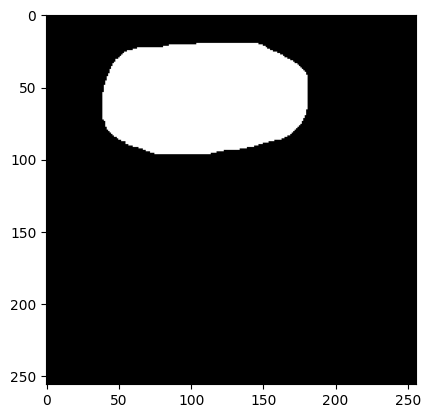

In [269]:
# dataiter = iter(train_loader)
# image, target = next(dataiter)
# image, target = image.to(device), target.to(device)
# pred = model(image)

# print(image.shape, target.shape, pred.shape)
# test = target[0].cpu().numpy()
# plt.imshow(test, cmap='gray')
# input = image
# target

0번째 모델
5번째 모델
10번째 모델
15번째 모델


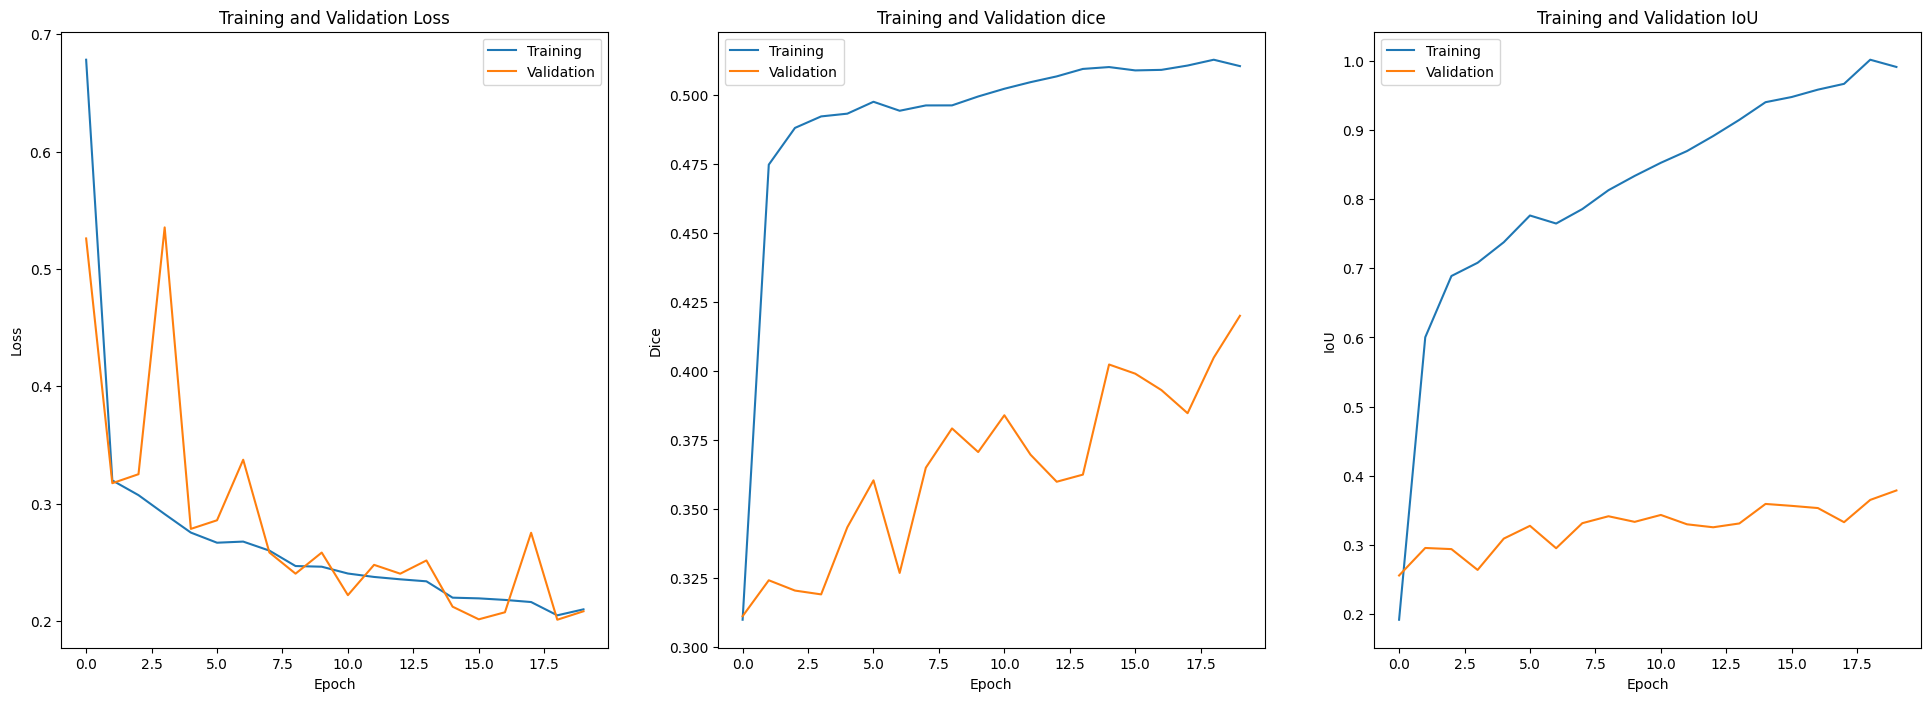

In [126]:
model_path = '/content/drive/MyDrive/03.Breast Cancer Segmentation/model_weights/240604_train1/'
model_files = os.listdir(model_path)
model_files = [os.path.join(model_path,i) for i in model_files]
model_files = [file for file in model_files if 'best' not in file]

model = UNet(num_classes=3)  # num_classes는 출력 클래스 수에 따라 조정
# state = torch.load(model_files[0])
# model.load_state_dict(state['model'])
# 학습 결과 dictionary 생성
history_dic = {'epoch': [], 'valid_loss': [], 'valid_dice': [], 'valid_iou': [], 'train_loss': [], 'train_dice': [], 'train_iou': []}
for i, model_file in enumerate(model_files):
    if i % 5 == 0:
        print(f'{i}번째 모델')
    state = torch.load(model_file)
    model.load_state_dict(state['model'])
    epoch = state['epoch']
    valid_loss = state['valid_loss']
    valid_dice = state['valid_dice'].detach().cpu().numpy().tolist()
    valid_iou = state['valid_iou'].detach().cpu().numpy().tolist()
    train_loss = state['train_loss'].detach().cpu().numpy().tolist()
    train_dice = state['train_dice'].detach().cpu().numpy().tolist()
    train_iou = state['train_iou'].detach().cpu().numpy().tolist()

    history_dic['epoch'].append(epoch)
    history_dic['valid_loss'].append(valid_loss)
    history_dic['train_loss'].append(train_loss)
    history_dic['valid_dice'].append(valid_dice)
    history_dic['train_dice'].append(train_dice)
    history_dic['valid_iou'].append(valid_iou)
    history_dic['train_iou'].append(train_iou)
# 시각화
fig, axs = plt.subplots(1, 3, figsize=(24,8))

axs[0].plot(history_dic['epoch'], history_dic['train_loss'], label='Training')
axs[0].plot(history_dic['epoch'], history_dic['valid_loss'], label='Validation')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history_dic['epoch'], history_dic['train_dice'], label='Training')
axs[1].plot(history_dic['epoch'], history_dic['valid_dice'], label='Validation')
axs[1].set_title('Training and Validation dice')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Dice')
axs[1].legend()

axs[2].plot(history_dic['epoch'], history_dic['train_iou'], label='Training')
axs[2].plot(history_dic['epoch'], history_dic['valid_iou'], label='Validation')
axs[2].set_title('Training and Validation IoU')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('IoU')
axs[2].legend()

plt.show()

In [ ]:
# dataiter = iter(train_loader)
# image, target = next(dataiter)
# image, target = image.to(device), target.to(device)
# pred = model(image)

# print(image.shape, target.shape, pred.shape)

In [ ]:
# test_img = image[0].detach().cpu().numpy().transpose(1,2,0)
# plt.imshow(test_img)
# # test_img = outputs[0].detach().cpu().numpy().transpose(1,2,0)
# # test_img.shape
# # plt.imshow(test_img)

# 8. 8_Predict

In [ ]:
def evaluate(test_loader, model, output_path):
    model.eval()
    with torch.no_grad():
        for i, (input, target) in enumerate(test_loader):
            input_var = Variable(input).to(device)
            target_var = Variable(target).to(device)

            output = model(input_var)
            output = torch.softmax(output, dim=1)
            output = torch.argmax(output[0], dim=0).cpu().numpy()
            output_mask = class_to_rgb(output)

            cv2.imwrite(f'{output_path}/predicts/{i}.png', output_mask)
    print('finish')

# 텐서를 이미지로 변환하는 함수
def tensor2image(tensor_list):
    img = tensor_list[0].detach().cpu().numpy() #tensor -> numpy
    img = np.transpose(img, (1,2,0)) #[C,H,W] -> [H,W,C]
    img = img * 255.0
    img = img.astype(np.uint8).copy()
    return img

In [ ]:
# # zip압축해제
# !unzip '/content/drive/MyDrive/03.Breast Cancer Segmentation/03. Test Dataset.zip' -d '/content/03. Test Dataset/'

Archive:  /content/drive/MyDrive/03.Breast Cancer Segmentation/03. Test Dataset.zip
  inflating: /content/03. Test Dataset/image/benign1.png  
  inflating: /content/03. Test Dataset/image/benign10.png  
  inflating: /content/03. Test Dataset/image/benign100.png  
  inflating: /content/03. Test Dataset/image/benign101.png  
  inflating: /content/03. Test Dataset/image/benign102.png  
  inflating: /content/03. Test Dataset/image/benign103.png  
  inflating: /content/03. Test Dataset/image/benign104.png  
  inflating: /content/03. Test Dataset/image/benign105.png  
  inflating: /content/03. Test Dataset/image/benign106.png  
  inflating: /content/03. Test Dataset/image/benign107.png  
  inflating: /content/03. Test Dataset/image/benign108.png  
  inflating: /content/03. Test Dataset/image/benign109.png  
  inflating: /content/03. Test Dataset/image/benign11.png  
  inflating: /content/03. Test Dataset/image/benign110.png  
  inflating: /content/03. Test Dataset/image/benign111.png  
  inf

In [ ]:
# 테스트 데이터셋 정의
test_data_dir = '/content/03. Test Dataset'
test_img_path = os.path.join(data_dir, 'image')
test_mask_path = os.path.join(data_dir, 'mask')

# 이미지변환기 저장
channel_means = [0.485, 0.456, 0.406]
channel_stds = [0.229, 0.224, 0.225]

test_tfms = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(channel_means, channel_stds)])
mask_tfms = transforms.Compose([transforms.Resize(256)])

# 데이터셋
test_dataset = BreastDatasets(img_dir=test_img_path, img_transform=test_tfms, mask_dir=test_mask_path, mask_transform=mask_tfms)

# 데이터로더(num_workers: cpu가 병렬로 처리가 가능하다는 뜻(cpu코어갯수))
test_loader = DataLoader(test_dataset, 1, shuffle=False, num_workers=num_workers)

# 모델지정
model = UNet(num_classes=3)  # num_classes는 출력 클래스 수에 따라 조정
state = torch.load('/content/drive/MyDrive/03.Breast Cancer Segmentation/model_weights/240602_train2/model_epoch_49.pth')
model.load_state_dict(state['model'])
model.to(device)

#결과 저장 폴더 만들기
os.makedirs('/content/drive/MyDrive/03.Breast Cancer Segmentation/benign/predicts', exist_ok=True)

output_path = '/content/drive/MyDrive/03.Breast Cancer Segmentation/benign'
evaluate(test_loader, model, output_path)

finish


In [ ]:
test_data_dir = '/content/02. Unet_Dataset'
test_img_path = os.path.join(test_data_dir, 'image')
test_mask_path = os.path.join(test_data_dir, 'mask')

img_files = []
mask_files = []
for x in ['benign','malignant','normal']:
    file_img_dir = os.path.join(test_img_path,x)
    file_mask_dir = os.path.join(test_mask_path,x)
    for img_name in os.listdir(file_img_dir):
        if img_name.split('.')[-1] in ('png', 'jpg'):
            img_files.append(os.path.join(file_img_dir, img_name))
            mask_files.append(os.path.join(file_mask_dir, img_name))

['/content/02. Unet_Dataset/image/benign/benign398.png',
 '/content/02. Unet_Dataset/image/benign/benign81.png',
 '/content/02. Unet_Dataset/image/benign/benign385.png',
 '/content/02. Unet_Dataset/image/benign/benign97.png',
 '/content/02. Unet_Dataset/image/benign/benign90.png',
 '/content/02. Unet_Dataset/image/benign/benign428.png',
 '/content/02. Unet_Dataset/image/benign/benign185.png',
 '/content/02. Unet_Dataset/image/benign/benign169.png',
 '/content/02. Unet_Dataset/image/benign/benign32.png',
 '/content/02. Unet_Dataset/image/benign/benign253.png',
 '/content/02. Unet_Dataset/image/benign/benign327.png',
 '/content/02. Unet_Dataset/image/benign/benign187.png',
 '/content/02. Unet_Dataset/image/benign/benign373.png',
 '/content/02. Unet_Dataset/image/benign/benign305.png',
 '/content/02. Unet_Dataset/image/benign/benign416.png',
 '/content/02. Unet_Dataset/image/benign/benign89.png',
 '/content/02. Unet_Dataset/image/benign/benign37.png',
 '/content/02. Unet_Dataset/image/ben

In [ ]:
print(img_files[5], mask_files[5])

/content/02. Unet_Dataset/image/benign/benign428.png /content/02. Unet_Dataset/mask/benign/benign428.png


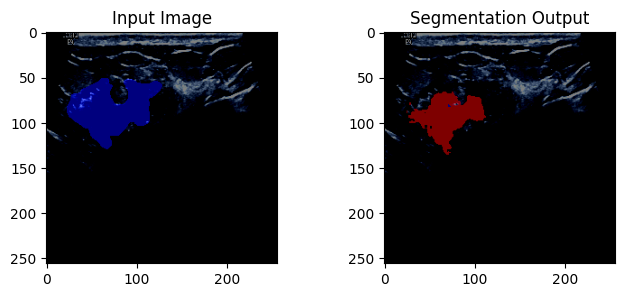

In [ ]:
index=450

train_tfms = transforms.Compose([transforms.ToTensor(), transforms.Resize(256),
                                 transforms.Normalize(channel_mean, channel_stds)])
img_path = img_files[index]
mask_path = mask_files[index]
# image = Image.open(img_path).convert('RGB')
image = cv2.imread(img_path)
mask = cv2.imread(mask_path)
# plt.imshow(image)
image = train_tfms(image).unsqueeze(0)
# image = transform(image) # 배치 차원을 추가
# image.shape
#예측수행
with torch.no_grad():
    image = image.to(device)  # GPU 사용 시
    output = model(image)
    # output = torch.softmax(output, dim=1).cpu().numpy()
    output = torch.softmax(output, dim=1)
    output = torch.argmax(output[0], dim=0).cpu().numpy()
    output_mask = class_to_rgb(output)
    # output = torch.sigmoid(output)  # 바이너리 세그멘테이션의 경우
    # output = (output > 0.5).float()  # 임계값 0.5로 이진화

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))
plt.imshow(mask, cmap='gray', alpha=0.5)


plt.subplot(1, 2, 2)
plt.title('Segmentation Output')
plt.imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))
plt.imshow(output_mask, cmap='gray',alpha=0.5)

plt.show()


torch.Size([1, 3, 256, 256])

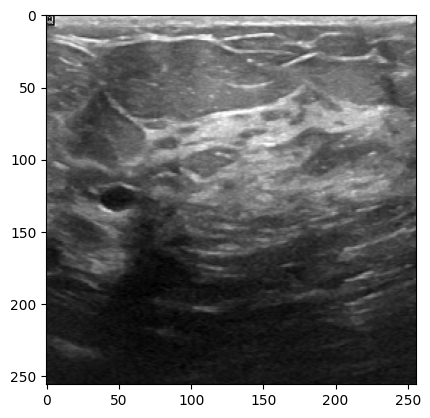

In [ ]:
train_tfms = transforms.Compose([transforms.ToTensor(), transforms.Resize(256),
                                 transforms.Normalize(channel_mean, channel_stds)])
img_path = test_files[index]
# image = Image.open(img_path).convert('RGB')
image = cv2.imread(img_path)
plt.imshow(image)
image = train_tfms(image).unsqueeze(0)
# image = transform(image) # 배치 차원을 추가
# image.shape

In [ ]:
#예측수행
with torch.no_grad():
    image = image.to(device)  # GPU 사용 시
    output = model(image)
    # output = torch.softmax(output, dim=1).cpu().numpy()
    output = torch.softmax(output, dim=1)
    output = torch.argmax(output[0], dim=0).cpu().numpy()
    output_mask = class_to_rgb(output)
    # output = torch.sigmoid(output)  # 바이너리 세그멘테이션의 경우
    # output = (output > 0.5).float()  # 임계값 0.5로 이진화

In [ ]:
np.unique(output)

array([0, 1, 2])

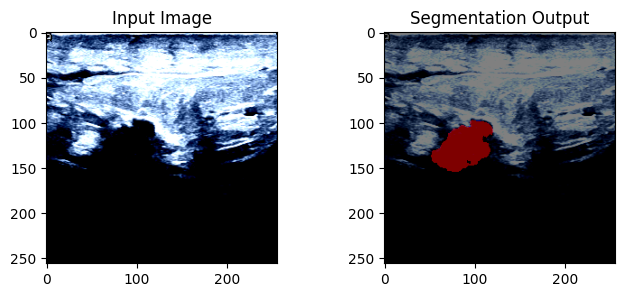

In [ ]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))

plt.subplot(1, 2, 2)
plt.title('Segmentation Output')
plt.imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))
plt.imshow(output_mask, alpha=0.5)

plt.show()
